In [1]:
from google.colab import drive
import os

In [2]:
ROOT = '/content/drive'
drive.mount(ROOT)

Mounted at /content/drive


In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

In [5]:
%cd drive/MyDrive/Clothes\ classification/input

/content/drive/MyDrive/Clothes classification/input


### Gpu

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Data Preprocessing

In [6]:
CATEGORIES = ['Jeans', 'Saree', 'Trousers']
IMG_SIZE = 256

In [10]:
image = []
label = []

for category in CATEGORIES:
  path = os.path.join(os.getcwd(), category)
  for img in os.listdir(path):
    image.append(img)
    label.append(category)

In [11]:
data = {'Images': image, 'Labels': label}
data = pd.DataFrame(data)
data.head()

,Images,Labels
0,cd5e736063.jpg,Jeans
1,b54f4e3077.jpg,Jeans
2,4336f00019.jpg,Jeans
3,531b42aa31.jpg,Jeans
4,7eb78ac188.jpg,Jeans


In [12]:
data.to_csv('image.csv', index=False)

In [14]:
# label encoding
le = LabelEncoder()
data['encoded_labels'] = le.fit_transform(data['Labels'])
data.head()

,Images,Labels,encoded_labels
0,cd5e736063.jpg,Jeans,0
1,b54f4e3077.jpg,Jeans,0
2,4336f00019.jpg,Jeans,0
3,531b42aa31.jpg,Jeans,0
4,7eb78ac188.jpg,Jeans,0


## Spliting Dataset

In [15]:
batch_size = 64
validation_split = .3
shuffle_dataset = True
random_seed = 42

In [16]:
dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [17]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

## Transforms

In [18]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [19]:
class Clothes_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'Labels'],
                                self.img_data.loc[index, 'Images'])
        image = Image.open(img_name)
        #image = image.convert('RGB')
        image = image.resize((300,300))
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [20]:
dataset = Clothes_Dataset(data,'/content/drive/MyDrive/Clothes classification/input',transform)

In [23]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [24]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

## Visualization

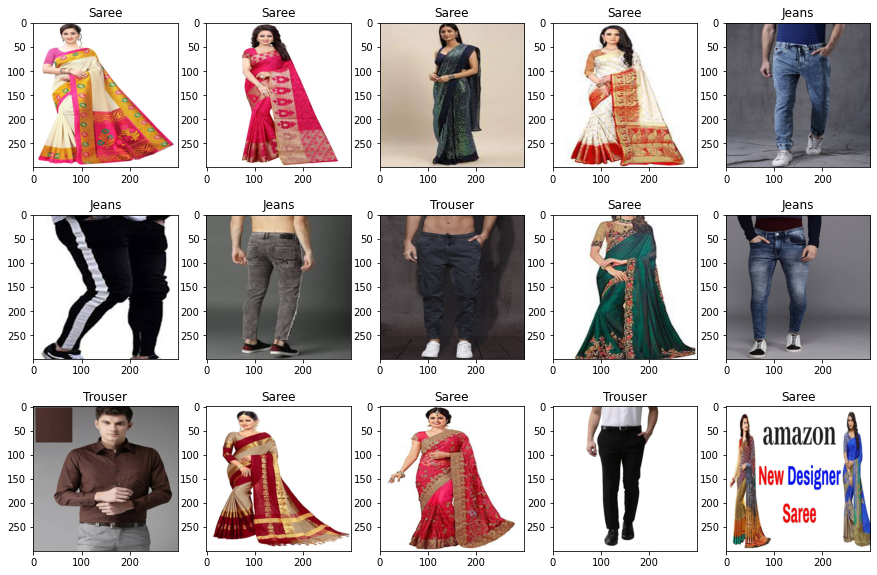

In [25]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
clothing_type = {0: 'Jeans', 1: 'Saree', 2: 'Trouser'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(img_display(image)) # add image
        ax.set(title = f"{clothing_type[label.item()]}") # add label

## Neural Network

In [44]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        model = models.resnet18()
        model.fc = nn.Sequential(
            nn.Linear(512, 3),
            nn.Softmax()
        )
        self.model = model
        
    def forward(self, x):
        x = self.model(x)
        return x

In [45]:
# model = Net() # Cpu
model = Net().to(device) # Gpu
print(model)

Net(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [29]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

## Training Network

In [47]:
n_epochs = 12
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    # scheduler.step(epoch)
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(device), target_.to(device)# on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (validation_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(validation_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), os.path.join(os.getcwd(), 'model_classification_tutorial.pt'))
            print('Detected network improvement, saving current model')
    model.train()

Epoch 1



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch [1/12], Step [0/12], Loss: 1.0969

train loss: 1.1014, train acc: 32.9640
validation loss: 1.0961, validation acc: 36.2460

Detected network improvement, saving current model
Epoch 2

Epoch [2/12], Step [0/12], Loss: 1.0860

train loss: 1.1047, train acc: 32.9640
validation loss: 1.0956, validation acc: 36.2460

Detected network improvement, saving current model
Epoch 3

Epoch [3/12], Step [0/12], Loss: 1.1263

train loss: 1.1054, train acc: 32.9640
validation loss: 1.0947, validation acc: 36.2460

Detected network improvement, saving current model
Epoch 4

Epoch [4/12], Step [0/12], Loss: 1.1058

train loss: 1.1066, train acc: 32.9640
validation loss: 1.0945, validation acc: 36.2460

Epoch 5

Epoch [5/12], Step [0/12], Loss: 1.1253

train loss: 1.1067, train acc: 32.9640
validation loss: 1.0948, validation acc: 36.2460

Epoch 6

Epoch [6/12], Step [0/12], Loss: 1.1035

train loss: 1.1070, train acc: 32.9640
validation loss: 1.0950, validation acc: 36.2460

Epoch 7

Epoch [7/12],

## Evaluation

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


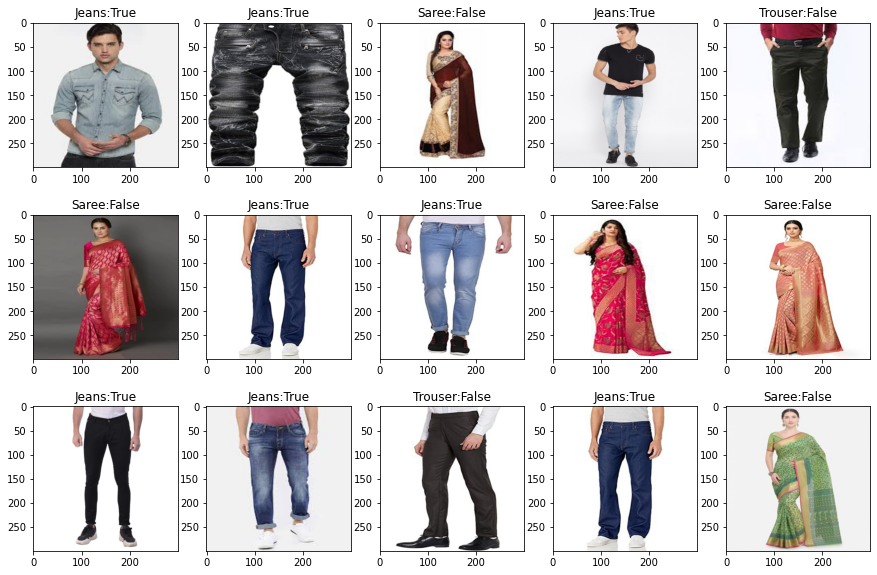

In [52]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
clothing_type = {0: 'Jeans', 1: 'Saree', 2: 'Trouser'}

# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
with torch.no_grad():
    model.eval()
    for ax, image, label in zip(axis.flat,images, labels):
        ax.imshow(img_display(image)) # add image
        image_tensor = image.unsqueeze_(0)
        image_tensor = image_tensor.to(device)
        output_ = model(image_tensor)
        output_ = output_.argmax()
        k = output_.item()==label.item()
        ax.set_title(str(clothing_type[label.item()])+":" +str(k)) # add label
